In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D,
    MaxPooling1D,
    LSTM,
    Bidirectional,
    Dropout,
    Flatten,
    Dense,
    Input,
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session

from utils import load_dataset, train, plot_roc, auc
from einops import rearrange
import matplotlib.pyplot as plt

[Reference](https://github.com/uci-cbcl/DanQ/blob/master/DanQ_train.py) 

In [17]:
clear_session()
model = Sequential(
    [
        Input((1000, 4)),
        Conv1D(64, kernel_size=26, activation="relu"),
        MaxPooling1D(pool_size=13, strides=13),
        Dropout(0.2),
        Bidirectional(LSTM(16, return_sequences=True)),
        Dropout(0.5),
        Flatten(),
        Dense(925, activation="relu"),
        Dense(31, activation="sigmoid"),
    ],
    name="danq_small",
)
model.summary()

Model: "danq_small"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 975, 64)           6720      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 75, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 64)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 75, 32)            10368     
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2400)              0         
_________________________________________________________________
dense (Dense)                (None, 925)               2

In [18]:
es = EarlyStopping(monitor="val_loss", patience=15)
optimizer = Adam(lr=1e-4)

epochs = 1000
validation_freq = 1
n = 2
file = f"MA0035_{n}000"

Epoch 1/1000
3125/3125 - 20s - loss: 0.6952 - acc: 0.5054 - val_loss: 0.6919 - val_acc: 0.5120
Epoch 2/1000
3125/3125 - 17s - loss: 0.6905 - acc: 0.5296 - val_loss: 0.6868 - val_acc: 0.5357
Epoch 3/1000
3125/3125 - 18s - loss: 0.6796 - acc: 0.5652 - val_loss: 0.6535 - val_acc: 0.6202
Epoch 4/1000
3125/3125 - 18s - loss: 0.5446 - acc: 0.7163 - val_loss: 0.3000 - val_acc: 0.8930
Epoch 5/1000
3125/3125 - 18s - loss: 0.2395 - acc: 0.9167 - val_loss: 0.1735 - val_acc: 0.9461
Epoch 6/1000
3125/3125 - 18s - loss: 0.1797 - acc: 0.9422 - val_loss: 0.1551 - val_acc: 0.9516
Epoch 7/1000
3125/3125 - 18s - loss: 0.1662 - acc: 0.9477 - val_loss: 0.1510 - val_acc: 0.9528
Epoch 8/1000
3125/3125 - 19s - loss: 0.1591 - acc: 0.9500 - val_loss: 0.1538 - val_acc: 0.9523
Epoch 9/1000
3125/3125 - 18s - loss: 0.1580 - acc: 0.9510 - val_loss: 0.1506 - val_acc: 0.9535
Epoch 10/1000
3125/3125 - 18s - loss: 0.1570 - acc: 0.9511 - val_loss: 0.1513 - val_acc: 0.9516
Epoch 11/1000
3125/3125 - 18s - loss: 0.1559 - ac

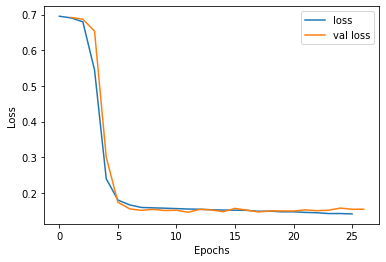

Training time: 7.95 minutes


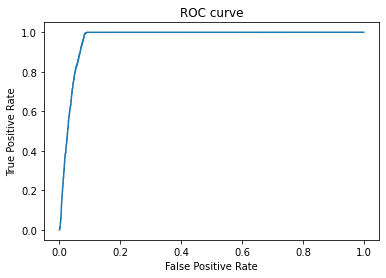

0.9683250600000001


In [19]:
X_train, y_train, X_test, y_test = load_dataset(file=file, labels="binlabels",)
X_train = rearrange(X_train, "w h c -> w c h")
X_test = rearrange(X_test, "w h c -> w c h")

model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["acc"],
)

model = train(
    dataset=(X_train, y_train, X_test, y_test),
    model=model,
    epochs=epochs,
    verbose=2,
    validation_freq=validation_freq,
    callbacks=[es],
)

y_pred = model.predict(X_test)
plot_roc(y_test, y_pred)
print(auc(y_test, y_pred))

In [21]:
model.save(f"../model_saves/evals/{model.name}-{n}000.h5")

------------------MA0035_1000------------------


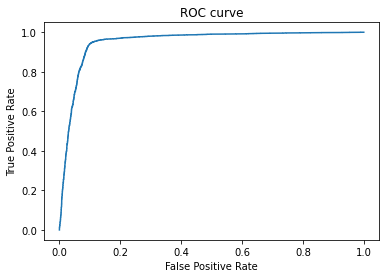

0.9504619999999999
------------------MA0035_2000------------------


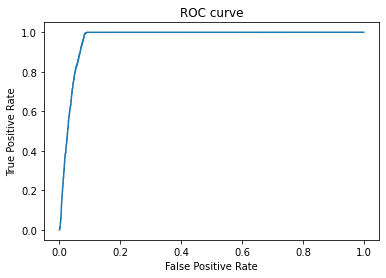

0.9683250600000001
------------------MA0035_3000------------------


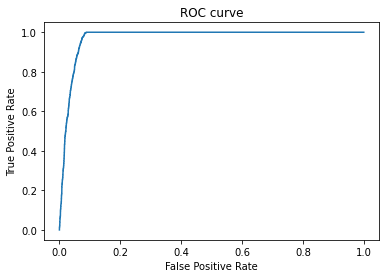

0.9725713600000001
------------------MA0035_5000------------------


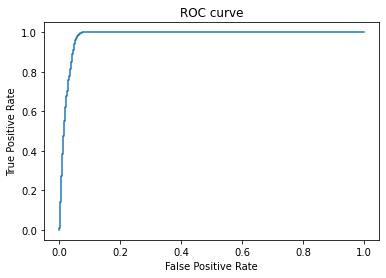

0.9805604800000001
------------------MA0035_10000------------------


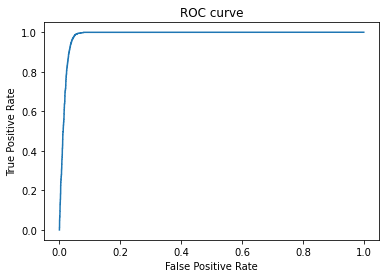

0.9849278600000001


In [20]:
for i in [1, 2, 3, 5, 10]:
    file = f"MA0035_{i}000"
    print(f"------------------{file}------------------")
    X_train, y_train, X_test, y_test = load_dataset(file=file, labels="binlabels",)
    X_train = rearrange(X_train, "w h c -> w c h")
    X_test = rearrange(X_test, "w h c -> w c h")
    y_pred = model.predict(X_test)
    plot_roc(y_test, y_pred)
    print(auc(y_test, y_pred))